In [1]:
#Mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing all the dataset related to problem
train = pd.read_csv("/content/drive/MyDrive/final_hackathon/train_data-1638436039700.csv")
test = pd.read_csv("/content/drive/MyDrive/final_hackathon/test_data-1638434844061.csv")
footfall = pd.read_csv("/content/drive/MyDrive/final_hackathon/foot_fall-1638434879770.csv")
discount = pd.read_csv("/content/drive/MyDrive/final_hackathon/discount_features-1638436205304.csv")

# 1. Time Related Features

In [4]:
def create_date_features(df):
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)  # 0: Winter, 1: Spring
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"]) # 2: Summer
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])  # 3: Fall
    return df

#Random noise
We will derive the shifted features with rolling mean. When we derive them, we add random noise to the data because it affects the generalizability ability when it is the same as the previous true value. In a way, we corrupt the data ourselves. In the size of the data set with random normal distribution, we will add to the features we want. It is very useful for time series problems.

In [5]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

#Lag/Shifted Features
Past real values. Since the future is best influenced by the most recent last period values, we turn them into features. We produce a feature for past sales values. We add previous sales features. In other words, we create an independent variable using the dependent variable. That's why we just added random noise.

In [6]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["city", "medicine"])['sales'].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [7]:
#Joining the columms of train data to form date
# cols=["year","month","day"]
# train['date'] = train[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

#joining the columns

In [5]:
train['date'] =  train['year'].astype(str)+'-'+train['month'].astype(str)+'-'+train['day'].astype(str)

In [6]:
test['date'] = test['year'].astype(str)+'-'+test['month'].astype(str)+'-'+test['day'].astype(str)

In [7]:
train['date'] = pd.to_datetime(train['date'])

In [8]:
test['date'] = pd.to_datetime(test['date'])

In [9]:
#Created a sub-sample of dataset because the data is very huge and the computational power is very less 
train = train.loc[train['date'] >= '2017-01-01']

In [10]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2017-01-02
Max date from train set: 2018-06-30


In [11]:
df = create_date_features(train)

In [12]:
df.head()

,year,month,day,city,medicine,sales,date,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,quarter,is_month_start,is_month_end,season
10882318,2017,1,2,1,1,28.0,2017-01-02,2,2,1,0,0,1,0,0,0
10882319,2017,1,2,1,2,72.0,2017-01-02,2,2,1,0,0,1,0,0,0
10882320,2017,1,2,1,3,128.0,2017-01-02,2,2,1,0,0,1,0,0,0
10882321,2017,1,2,1,4,20.0,2017-01-02,2,2,1,0,0,1,0,0,0
10882322,2017,1,2,1,5,4.0,2017-01-02,2,2,1,0,0,1,0,0,0


In [13]:
# We don't want the values to be mixed sorted because I will derive a lag. That's why we're sorting it.
df.sort_values(by=['city', 'medicine', 'date'], axis=0, inplace=True)

In [17]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182])

In [18]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["city", "medicine"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


In [19]:
df = roll_mean_features(df, [365, 546])

#Exponentially Weighted Mean Features
It makes more sense to take the moving average instead of past average it if there is seasonality and trend The weight we give to the closest value, which we call ewm. If it is high (alpha=0.99), it gives higher weight to the nearest period.

In [20]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["city", "medicine"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


In [21]:
#  alphas = [0.9, 0.8]
#  lags = [91, 98, 105, 112, 119]
#  df = ewm_features(df, alphas, lags)

#Custom Cost Function

1.   MAE: mean absolute error
2.   MAPE: mean absolute percentage error
3.   SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [14]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [20]:
df_test = create_date_features(test)

#Time-Based Validation Sets
We have one train set, and we need to have one validation set. We have to look at our own fault with it.

In [13]:
Y_train = df[df['date'] < '2018-03-31']['sales']
X_train = df[df['date'] < '2018-03-31'].drop(['date', 'sales', 'year'], axis=1)

In [14]:
Y_val = df[df['date'] > '2018-04-01']['sales']
X_val = df[df['date'] > '2018-04-01'].drop(['date', 'sales', 'year'], axis=1)

In [15]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((9489146,), (9489146, 13), (2203282,), (2203282, 13))

In [26]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 49.38097028032719
VALID SMAPE: 52.728550292665965


In [29]:
sample3

array([44.24795683, 49.7494519 , 49.7494519 , ..., 34.65455071,
       34.65455071, 34.65455071])

In [33]:
sample3 = pd.DataFrame(sample3)
sample3 = sample3.join(extracted_col)
sample3.head()

,0,id
0,44.247957,1
1,49.749452,2
2,49.749452,3
3,49.749452,4
4,49.749452,5


In [34]:
sample3 = sample3.rename(columns = {0:"sales"})

In [35]:
sample3.head()

,sales,id
0,44.247957,1
1,49.749452,2
2,49.749452,3
3,49.749452,4
4,49.749452,5


In [36]:
pd.DataFrame(sample3).to_csv('sample3.csv')

In [37]:
from google.colab import files
files.download("sample3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test['medicine'].nunique()

3289

In [ ]:
train = train.query('medicine > 0')

In [ ]:
train.head()

,year,month,day,city,medicine,sales,date
10882318,2017,1,2,1,1,28.0,2017-01-02
10882319,2017,1,2,1,2,72.0,2017-01-02
10882320,2017,1,2,1,3,128.0,2017-01-02
10882321,2017,1,2,1,4,20.0,2017-01-02
10882322,2017,1,2,1,5,4.0,2017-01-02


In [ ]:
#consider only those dates which are in discount dataset
train = train.loc[train['date'] >= '2017-01-01']

In [ ]:
train.shape

(11742027, 7)

In [ ]:
train_set = train[train['date'] < '2017-12-31']
validation_set = train[train['date'] > '2017-12-31']

In [17]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=100, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(X_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train, Y_train), (X_val, Y_val)], 
              verbose=20, 
              early_stopping_rounds=20)

[15:58:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:25] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:111.471	validation_1-rmse:139.778
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:98.4613	validation_1-rmse:130.657
[40]	validation_0-rmse:97.7182	validation_1-rmse:130.433
[60]	validation_0-rmse:97.5774	validation_1-rmse:130.467
Stopping. Best iteration:
[44]	validation_0-rmse:97.6736	validation_1-rmse:130.414



XGBRegressor(colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000,
             seed=0, subsample=0.7)

In [20]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
sample4 = xgb_model.predict(df_test.drop(['id','date', "year"], axis=1))

In [22]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, xgb_val_pred)))

Train rmse: 99.27752801799434
Validation rmse: 130.90015836640427


In [19]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

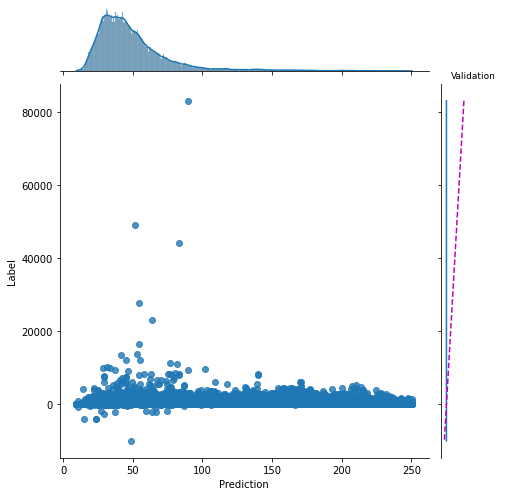

In [24]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_val, 'Validation')

In [45]:
pd.DataFrame(sample4).tail()

,0
773530,29.745365
773531,29.745365
773532,29.745365
773533,29.745365
773534,29.745365


In [46]:
sample4 = pd.DataFrame(sample4)

In [48]:
sample4.head()

,0
0,34.934376
1,54.377609
2,54.377609
3,54.377609
4,54.377609


In [50]:
sample4 = sample4.rename(columns = {0:"sales"})

In [51]:
test1 = pd.read_csv("/content/drive/MyDrive/final_hackathon/test_data-1638434844061.csv")

In [52]:
#Extracting a id column 
extracted_col = test1['id']

In [53]:
display(extracted_col)

0              1
1              2
2              3
3              4
4              5
           ...  
773530    773531
773531    773532
773532    773533
773533    773534
773534    773535
Name: id, Length: 773535, dtype: int64

In [54]:
sample4 = sample4.join(extracted_col)

In [55]:
sample4.head()

,sales,id
0,34.934376,1
1,54.377609,2
2,54.377609,3
3,54.377609,4
4,54.377609,5


In [56]:
pd.DataFrame(sample4).to_csv('sample4.csv')

In [57]:
from google.colab import files
files.download("sample4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Random forest

In [16]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [17]:
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)

In [21]:
rf_test_pred = rf_model.predict(df_test.drop(['date', 'id', 'year'], axis=1))

In [22]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, rf_val_pred)))

Train rmse: 98.61749869223392
Validation rmse: 130.0938647541267


In [ ]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(rf_val_pred, Y_val, 'Validation')

In [ ]:
pd.DataFrame(rf_test_pred).head()

In [ ]:
sample1 = pd.DataFrame(rf_test_pred)

In [ ]:
sample1 = sample1.join(extracted_col)

In [ ]:
sample1.head()

In [ ]:
sample1 = sample1.rename(columns = {0:"sales"})

In [ ]:
pd.DataFrame(sample1).to_csv('sample1.csv')

In [ ]:
sample1.head()

In [ ]:
from google.colab import files
files.download("sample1.csv")

#linear regression

In [ ]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train)
lr_train = lr_scaler.transform(X_train)
lr_val = lr_scaler.transform(X_val)
lr_test = lr_scaler.transform(df_test)

In [ ]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, Y_train)

In [ ]:
lr_train_pred = lr_model.predict(X_train)
lr_val_pred = lr_model.predict(X_val)
lr_test_pred = lr_model.predict(test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lr_val_pred)))

Train rmse: 105.13869089456969
Validation rmse: 116.97640995817284


In [ ]:
pd.DataFrame(lr_test_pred).tail()

,0
773530,45.818438
773531,45.818749
773532,45.816574
773533,45.819059
773534,45.785514


In [ ]:
sample2 = pd.DataFrame(lr_test_pred)
sample2 = sample2.join(extracted_col)
sample2.head()

,0,id
0,57.209897,1
1,56.808911,2
2,56.809222,3
3,56.809532,4
4,56.809843,5


In [ ]:
sample2 = sample2.rename(columns = {0:"sales"})
pd.DataFrame(sample2).to_csv('sample2.csv')

In [ ]:
sample2.head()

,sales,id
0,57.209897,1
1,56.808911,2
2,56.809222,3
3,56.809532,4
4,56.809843,5


In [ ]:
from google.colab import files
files.download("sample2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>